# Modeling Cas9 PID through RBM

In [ ]:
import sys
import os
import random
import warnings
import subprocess
import time
import multiprocessing
sys.path.append(os.path.dirname(os.getcwd()))
warnings.filterwarnings("ignore")

from tqdm import tqdm_notebook
from random import shuffle

from torch import optim
from torch.utils.data import DataLoader

from torchpgm.model import *
from torchpgm.layers import *
from torchpgm.data import RBMDataWithPAM, RBMData

from scipy.ndimage import *
from sklearn.metrics import * 
from sklearn.linear_model import *
from sklearn.multioutput import MultiOutputClassifier

from utils import *
from config import *


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [ ]:
device = "cuda"
folder = f"{DATA}/vink"

batch_size = 300
Nh = 200
Npam = 5
n_epochs = 1000
start_supervision_epoch = 20
l1b = 0.0025
l2 = 0.05
lambda_pa = 0.00
lr = 0.0001

model_full_name = f"rbmssl_pid_h{Nh}_npam{Npam}"

## The Standard RBM

We load the data. More details about how to build these data file are provided in the appropriated notebook

In [ ]:
train_dataset = RBMData(f"{folder}/data.pt", subset = "train")
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

val_dataset = RBMData(f"{folder}/data.pt", subset = "val")
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

Starting point for the potentials

In [ ]:
q_pi, N_pi = train_dataset[0][0].size()

g_pi = torch.zeros(q_pi, N_pi)
for x_pi, _, w, _ in train_dataset:
    g_pi += w* x_pi
g_pi = np.log(1+g_pi)
W = sum(train_dataset.weights)
g_pi = (g_pi - g_pi.mean(0)[None]).flatten()/W

We load the model

In [ ]:
model_full_name = f"rbm_pid_h{Nh}_npam{Npam}"
visible_layers = ["pi"]
hidden_layers = ["hidden"]

pi = OneHotLayer(None, N=N_pi, q=q_pi, name="pi")
h = GaussianLayer(N=Nh, name="hidden")

E = [(pi.name, h.name)]
E.sort()

model_rbm = PI_RBM(layers= {pi.name: pi, h.name: h}, edges=E, name = model_full_name)
optimizer = optim.AdamW(model_rbm.parameters(), lr=lr)

model_rbm = model_rbm.to(device)
#best_epoch = 180
#model_rbm.load(f"{folder}/weights/{model_full_name}_{best_epoch}.h5")
model_rbm.ais()

We train the model

In [ ]:
for epoch in range(1, n_epochs):
    model_rbm.train_epoch(optimizer, train_loader, train_dataset, 
                          regularizer = {"l1b" : l1b, "l2": l2, "l1b_pam": 0}, 
                          epoch = epoch, savepath=f"{folder}/weights/{model_full_name}")
    shuffle(train_dataset.x_m)

    if not epoch % 5:
        model_rbm.ais()
        model_rbm.val(val_loader, visible_layers, hidden_layers, epoch)

We evaluate the model

In [ ]:
model_rbm.eval()
model_rbm.ais()

print("Training set")
model_rbm.val(train_loader, visible_layers, hidden_layers, 0)

print("Validation set")
model_rbm.val(val_loader, visible_layers, hidden_layers, 0)

model_rbm = model_rbm.to("cpu")
device = "cpu"

## The Semi-Supervised Learning RBM

We load the data. More details about how to build these data file are provided in the appropriated notebook

In [7]:
train_dataset = RBMData(f"{folder}/data.pt", subset = "train")    
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

val_dataset = RBMData(f"{folder}/data.pt", subset = "val")
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

train_dataset_labelled = RBMDataWithPAM(f"{folder}/data.pt", Npam, subset = "train_labelled")
train_loader_labelled = DataLoader(train_dataset_labelled, batch_size = batch_size, shuffle = True)

val_dataset_labelled = RBMDataWithPAM(f"{folder}/data.pt", Npam, subset = "val_labelled")
val_loader_labelled = DataLoader(val_dataset_labelled, batch_size = batch_size, shuffle = False)

Available :  pi_seq L labelled subset weights x y
Available :  pi_seq L labelled subset weights x y
Available :  pi_seq L labelled subset weights x y
Available :  pi_seq L labelled subset weights x y


Starting point for the potentials

In [8]:
q_pi, N_pi = train_dataset[0][0].size()
g_pi = torch.zeros(q_pi, N_pi)
for x_pi, _, w, _ in train_dataset:
    g_pi += w* x_pi
g_pi = np.log(1+g_pi)
W = sum(train_dataset.weights)
g_pi = (g_pi - g_pi.mean(0)[None]).flatten()/W

We load the model

In [9]:
device = "cuda"

pi = OneHotLayer(g_pi, N=N_pi, q=q_pi, name="pi")
h = GaussianLayer(N=Nh, name="hidden")

classifier = PAM_classifier(Nh, Npam * 4, dropout = 0.)
E = [(pi.name, h.name)]
E.sort()

gamma = 5

model_rbm_ssl = PI_RBM_SSL(classifier, layers= {pi.name: pi, h.name: h}, edges=E, name = "")
optimizer = optim.AdamW(model_rbm_ssl.parameters(), lr=lr)
model_rbm_ssl = model_rbm_ssl.to(device)

We train the model using both training set :
- The set of unlabelled sequences
- The set of labelled sequences

In [ ]:
for epoch in range(1, 181):
    model_rbm_ssl.train_epoch_classifier(optimizer, train_loader, train_loader_labelled, train_dataset, train_dataset_labelled, 
                                     regularizer = {"l1b" : l1b, "l2":l2 , "l1b_pam": 0}, 
                                     epoch = epoch, savepath=f"{folder}/weights/{model_full_name}")
    shuffle(train_dataset_labelled.x_m)
    shuffle(train_dataset.x_m)

    if not epoch % 5:
        model_rbm_ssl.ais()
        model_rbm_ssl.val(val_loader, visible_layers, hidden_layers, epoch)
        model_rbm_ssl.val_classifier(val_loader_labelled, visible_layers, hidden_layers, epoch)

In [ ]:
model_rbm_ssl.eval()
model_rbm_ssl.ais()

print("Training set")
model_rbm_ssl.val(train_loader, visible_layers, hidden_layers, 0)
model_rbm_ssl.val_classifier(train_loader_labelled, visible_layers, hidden_layers, 0)

print("Validation set")
model_rbm_ssl.val(val_loader, visible_layers, hidden_layers, 0)
model_rbm_ssl.val_classifier(val_loader_labelled, visible_layers, hidden_layers, 0)

model_rbm = model_rbm.to("cpu")
device = "cpu"

## Study on the effect of gamma on the quality of the model

For each value of $\gamma$, we train one SSL-RBM on the same training and validation sets. Training also possible using the script `train_all_rbm.py`

In [ ]:
for gamma in gammas:
    torch.cuda.empty_cache()
    train_dataset = RBMData(f"{folder}/data.pt", subset = "train" )
    train_loader = DataLoader(train_dataset, batch_size = 100, shuffle = True, drop_last=True)

    val_dataset = RBMData(f"{folder}/data.pt", subset = "val")
    val_loader = DataLoader(val_dataset, batch_size = 300, shuffle = False)

    train_dataset_labelled = RBMDataWithPAM(f"{folder}/data.pt", Npam, subset = "train_labelled")
    train_loader_labelled = DataLoader(train_dataset_labelled, batch_size = 11, shuffle = True, drop_last=True)

    val_dataset_labelled = RBMDataWithPAM(f"{folder}/data.pt", Npam, subset = "val_labelled")
    val_loader_labelled = DataLoader(val_dataset_labelled, batch_size = 300, shuffle = False)
    
    q_pi, N_pi = train_dataset[0][0].size()
    g_pi = torch.zeros(q_pi, N_pi)
    for x_pi, _, w, _ in train_dataset:
        g_pi += w* x_pi
    g_pi = np.log(1+g_pi)
    W = sum(train_dataset.weights)
    g_pi = (g_pi - g_pi.mean(0)[None]).flatten()/W
    
    device = "cuda"
    folder = f"{DATA}/cas9/vink"
    model_full_name = f"rbmssl_pid_h{Nh}_npam{Npam}"    
    visible_layers = ["pi"]
    hidden_layers = ["hidden"]

    pi = OneHotLayer(None, N=N_pi, q=q_pi, name="pi")
    h = GaussianLayer(N=Nh, name="hidden")
    classifier = PAM_classifier(Nh, Npam * 4, dropout = 0.)
    E = [(pi.name, h.name)]
    E.sort()

    model_rbm = PI_RBM_SSL(classifier, layers= {pi.name: pi, h.name: h}, edges=E, gamma = gamma, name = f"classifier_{model_full_name}")
    optimizer = optim.AdamW(model_rbm.parameters(), lr=lr)
    model_rbm = model_rbm.to("cuda")
    model_rbm.ais()
    
    for epoch in range(1, 181):
        model_rbm.train_epoch_classifier(optimizer, train_loader, train_loader_labelled, train_dataset, train_dataset_labelled, 
                                         regularizer = {"l1b" : l1b, "l2":l2 , "l1b_pam": 0}, 
                                         epoch = epoch, savepath=f"{folder}/weights/c{model_full_name}")
        shuffle(train_dataset_labelled.x_m)
        shuffle(train_dataset.x_m)

        if not epoch % 5:
            model_rbm.ais()
            model_rbm.val(val_loader, visible_layers, hidden_layers, epoch)
            model_rbm.val_classifier(val_loader_labelled, visible_layers, hidden_layers, epoch)

In [17]:
Npam=5
train_dataset_labelled = RBMDataWithPAM(f"{DATA}/vink/data.pt", Npam, subset = "train_labelled")
val_dataset_labelled = RBMDataWithPAM(f"{DATA}/vink/data.pt", Npam, subset = "val_labelled")
val_loader_labelled = DataLoader(val_dataset_labelled, batch_size = 1000, shuffle = False)

spears = []
es = []
preds = []
cs = []
X_train = torch.stack(train_dataset_labelled.x_d,0).detach().float()
Y_train = train_dataset_labelled.y
X_test = torch.stack(val_dataset_labelled.x_d,0).detach().float()
Y_test = val_dataset_labelled.y

model_rbm_ssl = model_rbm_ssl.to("cpu")
with torch.no_grad():
    for gamma in tqdm_notebook(gammas):
        model_full_name = f"rbmssl_pid_h{Nh}_npam{Npam}_gamma{gamma}"
        model_rbm_ssl.load(f"{DATA}/vink/weights/{model_full_name}_90.h5")
        model_rbm_ssl.eval()
       # model_rbm_ssl = model_rbm_ssl.to("cuda")
        
        h_train = model_rbm_ssl.edges["pi -> hidden"](X_train, sample = False)
        h_test = model_rbm_ssl.edges["pi -> hidden"](X_test, sample = False)        
        c = model_rbm_ssl.classifier(h_test)

        clf = MultiOutputClassifier(LogisticRegression()).fit(h_train, Y_train)
        pred_reg = np.array([x for x in clf.predict_proba(h_test)])
        preds.append([np.mean([roc_auc_score(y,pred) for y, pred in zip(Y_test.T, c.T) if ((sum(y)>0) and (sum(1-y)>0))]), 
                      np.mean([roc_auc_score(y,pred) for y, pred in zip(Y_test.T, pred_reg[:,:,1]) if ((sum(y)>0) and (sum(1-y)>0))])])

Available :  pi_seq L labelled subset weights x y
Available :  pi_seq L labelled subset weights x y


In [ ]:
h_train = model_rbm_ssl.edges["pi -> hidden"](X_train, sample = False)
h_test = model_rbm_ssl.edges["pi -> hidden"](X_test, sample = False)        
c = model_rbm_ssl.classifier(h_test)

clf = MultiOutputClassifier(LogisticRegression()).fit(h_train, Y_train)
pred_reg = np.array([x for x in clf.predict_proba(h_test)])
preds.append([np.mean([roc_auc_score(y,pred) for y, pred in zip(Y_test.T, c.T) if ((sum(y)>0) and (sum(1-y)>0))]), 
              np.mean([roc_auc_score(y,pred) for y, pred in zip(Y_test.T, pred_reg[:,:,1]) if ((sum(y)>0) and (sum(1-y)>0))])])


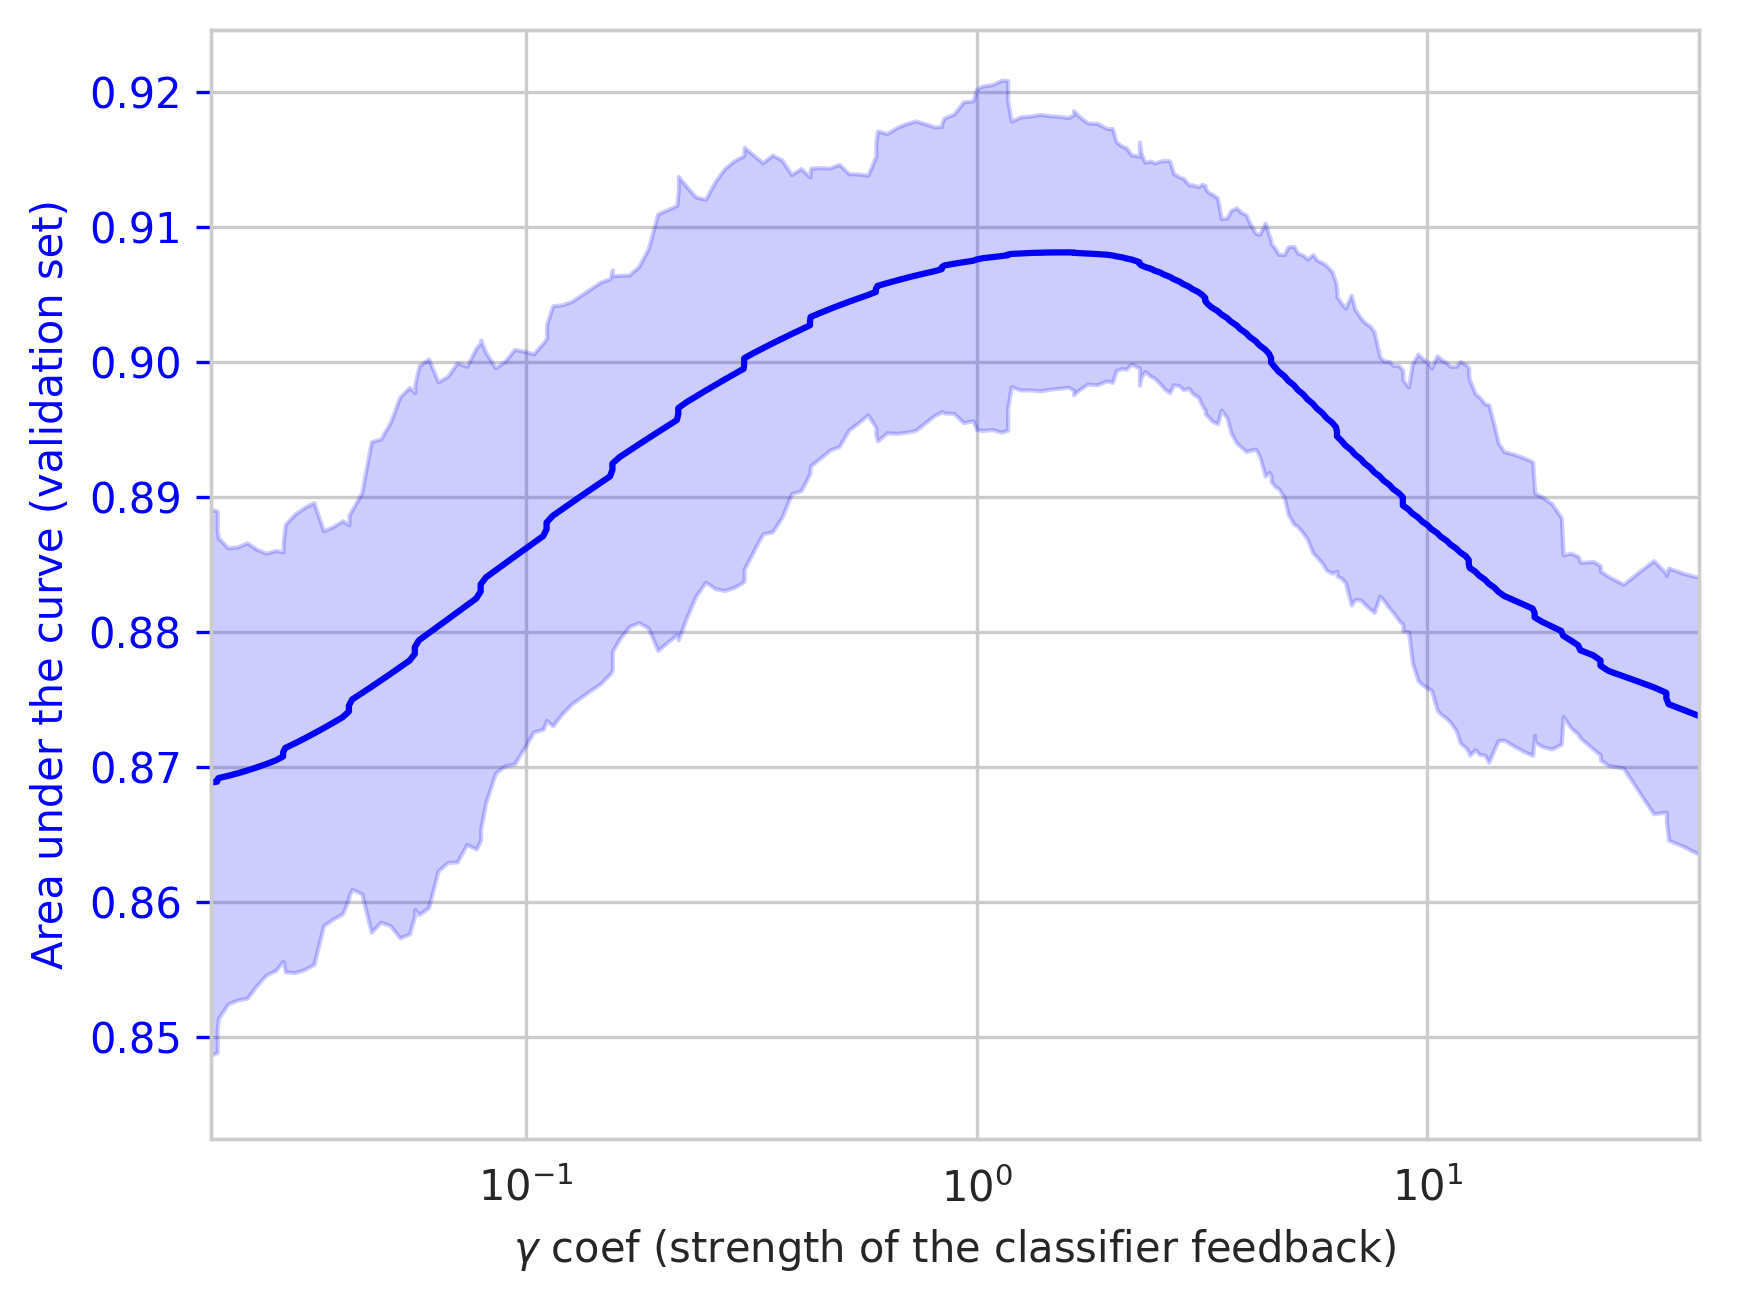

In [18]:
n = 20
fig, ax = plt.subplots()

# Twin the x-axis twice to make independent y-axes.
axes = [ax, ax.twinx()]

axes[-1].set_frame_on(True)
axes[-1].patch.set_visible(False)

axes[-1].set_yticks(ticks=[])

# And finally we get to plot things...
colors = ('Red', 'Blue', 'Green')

values = np.array([x[0] for x in preds])
fvalues = gaussian_filter1d(values[1:],n, mode="nearest")
errors = np.array([np.std(values[i:i+n]) for i in range(1,len(values)-n)])
axes[0].plot(gammas[1:], gaussian_filter1d(values[1:], n,  mode="nearest"), c="blue")
axes[0].fill_between(gammas[n//2+1:-n//2], fvalues[n//2:-n//2]-errors, fvalues[n//2:-n//2]+errors, color="blue", alpha = 0.2)
axes[0].set_ylabel('Area under the curve (validation set)' , color=colors[1])
axes[0].tick_params(axis='y', colors=colors[1])


plt.xscale("log")
plt.xlim(0.02,40)
axes[0].set_xlabel("$\gamma$ coef (strength of the classifier feedback)")
plt.show()

## Model Validation

In [ ]:
best_epoch = 90
model_rbm.load(f"{folder}/weights/{model_full_name}_{best_epoch}.h5")

In [ ]:
model_rbm.eval()
model_rbm.ais()

In [ ]:
model_rbm.val(train_loader, visible_layers, hidden_layers, 0)
model_rbm.val_classifier(train_loader_labelled, visible_layers, hidden_layers, 0)

In [ ]:
model_rbm.val(val_loader, visible_layers, hidden_layers, 0)
model_rbm.val_classifier(val_loader_labelled, visible_layers, hidden_layers, 0)

In [ ]:
model_rbm = model_rbm.to("cpu")
device = "cpu"